# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
import pandas as pd
import numpy as np

import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#spark imports
from pyspark.sql import SparkSession, Window
# from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number, rand, concat, desc, explode
# from pyspark.sql.functions import countDistinct as fcountDistinct
# from pyspark.sql.functions import sum as fsum
# from pyspark.sql.functions import min as fmin
# from pyspark.sql.functions import max as fmax
# from pyspark.sql.functions import lit
# from pyspark.sql.functions import when as fwhen
from pyspark.sql import functions as F
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier, LinearSVC
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, StandardScaler, StringIndexer, VectorAssembler
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder


In [2]:
# create a Spark session
spark = SparkSession.builder.appName("Sparkify").getOrCreate()

In [3]:
# checking spark working and its details
spark

In [4]:
spark.sparkContext.getConf().getAll()

[('spark.driver.port', '38595'),
 ('spark.app.id', 'local-1702271482172'),
 ('spark.rdd.compress', 'True'),
 ('spark.app.name', 'Sparkify'),
 ('spark.driver.host',
  '6a42d183c86c0509da164fce7124b353d0602185-7667ff6788-l8lz4'),
 ('spark.serializer.objectStreamReset', '100'),
 ('spark.master', 'local[*]'),
 ('spark.executor.id', 'driver'),
 ('spark.submit.deployMode', 'client'),
 ('spark.ui.showConsoleProgress', 'true')]

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [5]:
df = spark.read.json('mini_sparkify_event_data.json')

In [6]:
df.count()

286500

In [7]:
len(df.columns)

18

In [8]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [9]:
df.show(5, False)

+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------------------+------+-------------+---------------------------------------------------------------------------------------------------------------+------+
|artist          |auth     |firstName|gender|itemInSession|lastName|length   |level|location                      |method|page    |registration |sessionId|song                         |status|ts           |userAgent                                                                                                      |userId|
+----------------+---------+---------+------+-------------+--------+---------+-----+------------------------------+------+--------+-------------+---------+-----------------------------+------+-------------+---------------------------------------------------------------------------------------------------------------+------+
|Martha Tilston  |Logg

In [10]:
df.groupBy('userId').count().show()

+------+-----+
|userId|count|
+------+-----+
|100010|  381|
|200002|  474|
|   125|   11|
|    51| 2464|
|   124| 4825|
|     7|  201|
|    54| 3437|
|    15| 2278|
|   155| 1002|
|   132| 2304|
|   154|  118|
|100014|  310|
|   101| 2149|
|    11|  848|
|   138| 2469|
|300017| 4428|
|    29| 3603|
|    69| 1342|
|100021|  319|
|    42| 4257|
+------+-----+
only showing top 20 rows



In [11]:
df.groupBy('userId').count().orderBy('count').show()

+------+-----+
|userId|count|
+------+-----+
|   135|    6|
|   156|    6|
|   125|   11|
|100011|   23|
|300003|   35|
|100024|   36|
|    22|   40|
|100006|   44|
|   133|   44|
|    90|   45|
|    68|   48|
|   134|   52|
|   122|   62|
|    64|   68|
|    34|   73|
|100017|   75|
|200007|   76|
|100003|   78|
|   116|   79|
|200012|   84|
+------+-----+
only showing top 20 rows



In [12]:
df.groupBy('userId').count().orderBy('count', ascending=False).show()

+------+-----+
|userId|count|
+------+-----+
|    39| 9632|
|      | 8346|
|    92| 7230|
|   140| 6880|
|300011| 5732|
|   124| 4825|
|300021| 4659|
|300017| 4428|
|    85| 4370|
|    42| 4257|
|200023| 3769|
|     6| 3761|
|    29| 3603|
|    54| 3437|
|   100| 3214|
|     9| 3191|
|   126| 3102|
|300015| 3051|
|    91| 3014|
|    98| 2891|
+------+-----+
only showing top 20 rows



In [13]:
df.describe('userId').show()

+-------+------------------+
|summary|            userId|
+-------+------------------+
|  count|            286500|
|   mean| 59682.02278593872|
| stddev|109091.94999910535|
|    min|                  |
|    max|                99|
+-------+------------------+



In [14]:
#Finding and cleaning Nan/Null/empty values 
df.filter(df['userId'].isNull()).count()

0

In [15]:
df.filter(df['userId']=='').count()

8346

In [16]:
df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 58392|   0|     8346|  8346|            0|    8346| 58392|    0|    8346|     0|   0|        8346|        0|58392|     0|  0|     8346|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [17]:
df_notNull = df.na.drop()
df.count(), df_notNull.count()

(286500, 228108)

In [18]:
df_notNull.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId|song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+
|     0|   0|        0|     0|            0|       0|     0|    0|       0|     0|   0|           0|        0|   0|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+----+------+---+---------+------+



In [19]:
df_notNull.filter(df_notNull['userId']=='').count()

0

In [20]:
df_filtered = df.filter(df['userId'] != '')
df.count(), df_filtered.count(), df_notNull.count()

(286500, 278154, 228108)

In [21]:
df_filtered.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
|artist|auth|firstName|gender|itemInSession|lastName|length|level|location|method|page|registration|sessionId| song|status| ts|userAgent|userId|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+
| 50046|   0|        0|     0|            0|       0| 50046|    0|       0|     0|   0|           0|        0|50046|     0|  0|        0|     0|
+------+----+---------+------+-------------+--------+------+-----+--------+------+----+------------+---------+-----+------+---+---------+------+



In [22]:
#moving ahead with df_notNull output
#changing its name, because its too long to type again and again
dfn = df_notNull

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

#discovering about timestamp

In [23]:
df.describe('ts').show()

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              286500|
|   mean|1.540956889810471...|
| stddev| 1.507543960819624E9|
|    min|       1538352117000|
|    max|       1543799476000|
+-------+--------------------+



In [24]:
df_filtered.describe('ts').show()

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              278154|
|   mean|1.540958915431858E12|
| stddev|1.5068287123339083E9|
|    min|       1538352117000|
|    max|       1543799476000|
+-------+--------------------+



In [25]:
df_notNull.describe('ts').show()

+-------+--------------------+
|summary|                  ts|
+-------+--------------------+
|  count|              228108|
|   mean|1.540971261994704...|
| stddev|1.5021965831700122E9|
|    min|       1538352117000|
|    max|       1543799476000|
+-------+--------------------+



discovering about lenth of somgs

In [26]:
df_notNull.select(df_notNull.length).show(5)

+---------+
|   length|
+---------+
|277.89016|
|236.09424|
| 282.8273|
|262.71302|
|223.60771|
+---------+
only showing top 5 rows



In [27]:
df_notNull.select(df_notNull.length).describe().show()

+-------+------------------+
|summary|            length|
+-------+------------------+
|  count|            228108|
|   mean|249.11718197783375|
| stddev| 99.23517921058324|
|    min|           0.78322|
|    max|        3024.66567|
+-------+------------------+



In [28]:
df_notNull.select(df_notNull.length).toPandas().describe()

,length
count,228108.000000
mean,249.117182
std,99.235179
min,0.783220
25%,199.888530
50%,234.500770
75%,277.158730
max,3024.665670


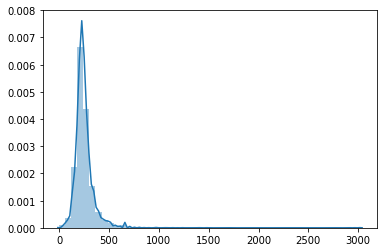

In [29]:
sns.distplot(df_notNull.select(df_notNull.length).toPandas())

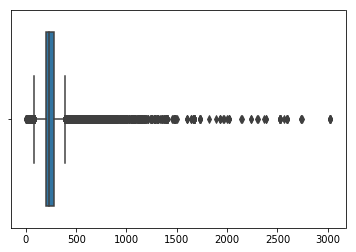

In [30]:
sns.boxplot(df_notNull.select(df_notNull.length).toPandas())

In [31]:
#discovering gender

In [32]:
df_gender = dfn.select(['userId', 'gender'])
print(df_gender.count())
df_gender.show(5)

print(df_gender.distinct().count())

228108
+------+------+
|userId|gender|
+------+------+
|    30|     M|
|     9|     M|
|    30|     M|
|     9|     M|
|    30|     M|
+------+------+
only showing top 5 rows

225


In [33]:
df_gender = df_gender.distinct()

count_gender = df_gender.groupBy('gender').count()
count_gender.show()

+------+-----+
|gender|count|
+------+-----+
|     F|  104|
|     M|  121|
+------+-----+



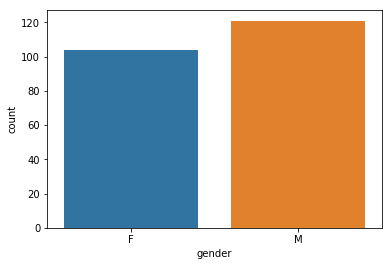

In [34]:
sns.barplot(x='gender', y='count', data=count_gender.toPandas())

In [35]:
# paid/free users

In [36]:
dfn.describe('level').show()

+-------+------+
|summary| level|
+-------+------+
|  count|228108|
|   mean|  null|
| stddev|  null|
|    min|  free|
|    max|  paid|
+-------+------+



In [37]:
dfn.select(dfn.level).toPandas().describe()

,level
count,228108
unique,2
top,paid
freq,186117


In [38]:
df_level = dfn.select(['userId', 'level']).distinct().groupBy('level').count()
df_level.show()

+-----+-----+
|level|count|
+-----+-----+
| free|  195|
| paid|  164|
+-----+-----+



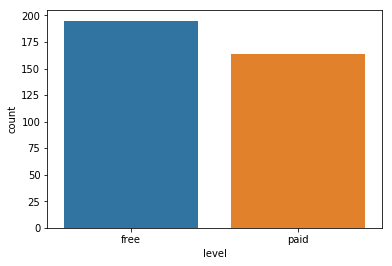

In [39]:
sns.barplot(x='level', y='count', data=df_level.toPandas())

In [40]:
dfn.describe('page').show()

+-------+--------+
|summary|    page|
+-------+--------+
|  count|  228108|
|   mean|    null|
| stddev|    null|
|    min|NextSong|
|    max|NextSong|
+-------+--------+



In [41]:
dfn.select(['page']).distinct().show()

+--------+
|    page|
+--------+
|NextSong|
+--------+



### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

In [42]:
churn_test= F.udf(lambda x : 1 if x=='Cancellation Confirmation' else 0, IntegerType())

In [43]:
df_churn = df_filtered.withColumn('Churn_test',churn_test('page'))
df_churn.describe('Churn_test').show()

+-------+--------------------+
|summary|          Churn_test|
+-------+--------------------+
|  count|              278154|
|   mean|1.869467992550889E-4|
| stddev|0.013671595449116171|
|    min|                   0|
|    max|                   1|
+-------+--------------------+



In [44]:
df_churn.filter(df_churn.Churn_test==1).show()

+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+----------+
|artist|     auth|firstName|gender|itemInSession| lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|Churn_test|
+------+---------+---------+------+-------------+---------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+----------+
|  null|Cancelled|   Adriel|     M|          104|  Mendoza|  null| paid|  Kansas City, MO-KS|   GET|Cancellation Conf...|1535623466000|      514|null|   200|1538943990000|"Mozilla/5.0 (Mac...|    18|         1|
|  null|Cancelled|    Diego|     M|           56|    Mckee|  null| paid|Phoenix-Mesa-Scot...|   GET|Cancellation Conf...|1537167593000|      540|null|   200

In [45]:
windowSelection = Window\
                    .partitionBy('userID')\
                    .rangeBetween(Window.unboundedPreceding, Window.unboundedFollowing)

df_churn = df_churn.withColumn('Churn', F.max('Churn_test').over(windowSelection))

In [46]:
df_churn.describe('Churn').show()

+-------+-------------------+
|summary|              Churn|
+-------+-------------------+
|  count|             278154|
|   mean|0.16129194618808287|
| stddev|0.36780068056308857|
|    min|                  0|
|    max|                  1|
+-------+-------------------+



In [47]:
df_churn.filter(df_churn.Churn==0).orderBy('userId').show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+----------+------+----------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-----+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|  location|method|      page| registration|sessionId|                song|status|           ts|           userAgent|userId|Churn_test|Churn|
+--------------------+---------+---------+------+-------------+--------+---------+-----+----------+------+----------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-----+
|     The Temper Trap|Logged In|   Brycen|     M|           19| Bradley|222.53669| paid|Laurel, MS|   PUT|  NextSong|1538159495000|        9|                Rest|   200|1538969140000|"Mozilla/5.0 (Mac...|    10|         0|    0|
|                null|Logged In|   Brycen|     M|           11| Bradley|     null| p

In [48]:
df_churn.filter(df_churn.Churn==0).orderBy('userId', ascending=False).show()

+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-----+
|          artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|Churn_test|Churn|
+----------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-----+
|    Rise Against|Logged In|  Madison|     F|           18|Atkinson|150.54322| free|New Haven-Milford...|   PUT|       NextSong|1531811983000|       98|          Gethsemane|   200|1538607743000|"Mozilla/5.0 (Win...|    99|         0|    0|
|     Paris Combo|Logged In|  Madison|  

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [49]:
#Checking impact of gender on the churn

In [50]:
df_gen = df_churn.select(['userId', 'Churn', 'gender']).distinct().groupBy('Churn', 'gender').count()
df_gen.show()

+-----+------+-----+
|Churn|gender|count|
+-----+------+-----+
|    1|     F|   20|
|    0|     M|   89|
|    1|     M|   32|
|    0|     F|   84|
+-----+------+-----+



In [51]:
print('Female churn percentage:', 20/84)
print('Male churn percentage:', 32/89)

Female churn percentage: 0.23809523809523808
Male churn percentage: 0.3595505617977528


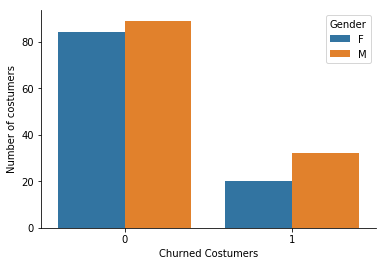

In [52]:
fig = sns.barplot(x='Churn', y='count', hue='gender', data=df_gen.toPandas())
plt.xlabel('Churned Costumers')
plt.ylabel('Number of costumers')
plt.legend(title='Gender')
sns.despine(ax=fig);

From the graph and percentage, we can see that, male costumers are more likely to chrun than female costumers

In [53]:
#Checking impact of level on the churn

In [54]:
df_lev = df_churn.select(['userId', 'Churn', 'level']).distinct().groupBy('Churn', 'level').count()
df_lev.show()

+-----+-----+-----+
|Churn|level|count|
+-----+-----+-----+
|    0| free|  149|
|    0| paid|  129|
|    1| paid|   36|
|    1| free|   46|
+-----+-----+-----+



In [55]:
print('Free user churn percentage:', 46/149)
print('Paid user churn percentage:', 36/129)

Free user churn percentage: 0.3087248322147651
Paid user churn percentage: 0.27906976744186046


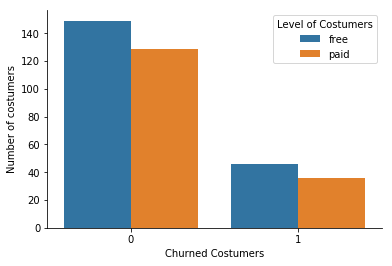

In [56]:
fig = sns.barplot(x='Churn', y='count', hue='level', data=df_lev.toPandas())
plt.xlabel('Churned Costumers')
plt.ylabel('Number of costumers')
plt.legend(title='Level of Costumers')
sns.despine(ax=fig);

From the graph and percentage, we can see that, there is no significant impact of level on churn

In [57]:
#checking the impact of user interactions

In [58]:
li_cols = ['Thumbs Up','Home','Add to','Add Friend','Roll Advert','Logout','Thumbs Down','Downgrade','Settings','Help','About','Upgrade','Save Settings','Error','Submit Upgrade','Submit Downgrade']

df_usr = df_churn.select(['userId', 'Churn', 'page']).distinct() \
    .groupBy('Churn', 'page').count().orderBy('page', 'count') \
    .where(F.col('page').isin(li_cols))

df_usr.show(100)

+-----+----------------+-----+
|Churn|            page|count|
+-----+----------------+-----+
|    1|           About|   31|
|    0|           About|  124|
|    1|      Add Friend|   44|
|    0|      Add Friend|  162|
|    1|       Downgrade|   35|
|    0|       Downgrade|  119|
|    1|           Error|   22|
|    0|           Error|   95|
|    1|            Help|   43|
|    0|            Help|  149|
|    1|            Home|   51|
|    0|            Home|  172|
|    1|          Logout|   46|
|    0|          Logout|  167|
|    1|     Roll Advert|   50|
|    0|     Roll Advert|  157|
|    1|   Save Settings|   30|
|    0|   Save Settings|  102|
|    1|        Settings|   43|
|    0|        Settings|  152|
|    1|Submit Downgrade|    9|
|    0|Submit Downgrade|   40|
|    1|  Submit Upgrade|   29|
|    0|  Submit Upgrade|  102|
|    1|     Thumbs Down|   48|
|    0|     Thumbs Down|  155|
|    1|       Thumbs Up|   50|
|    0|       Thumbs Up|  170|
|    1|         Upgrade|   37|
|    0| 

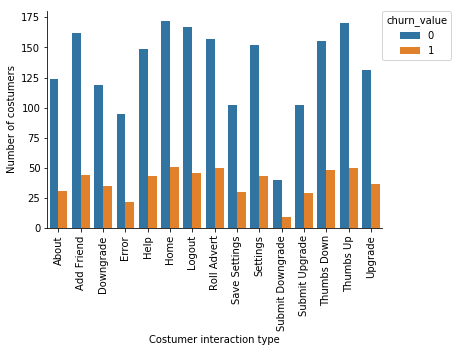

In [59]:
fig = sns.barplot(x='page', y='count', hue='Churn', data=df_usr.toPandas())
plt.xlabel('Costumer interaction type')
plt.ylabel('Number of costumers')
plt.xticks(rotation=90) 
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., title='churn_value')
sns.despine(ax=fig);

In [60]:
li_cols = ['Thumbs Up','Home','Add to','Add Friend','Roll Advert','Logout','Thumbs Down','Downgrade','Settings','Help','About','Upgrade','Save Settings','Error','Submit Upgrade','Submit Downgrade']

df_usr = df_churn.select(['userId', 'Churn', 'page']) \
    .groupBy('Churn', 'page').count().orderBy('page') \
    .where(F.col('page').isin(li_cols))

df_usr.show(100)

+-----+----------------+-----+
|Churn|            page|count|
+-----+----------------+-----+
|    1|           About|   56|
|    0|           About|  439|
|    0|      Add Friend| 3641|
|    1|      Add Friend|  636|
|    1|       Downgrade|  337|
|    0|       Downgrade| 1718|
|    0|           Error|  220|
|    1|           Error|   32|
|    0|            Help| 1215|
|    1|            Help|  239|
|    0|            Home| 8410|
|    1|            Home| 1672|
|    1|          Logout|  553|
|    0|          Logout| 2673|
|    0|     Roll Advert| 2966|
|    1|     Roll Advert|  967|
|    1|   Save Settings|   58|
|    0|   Save Settings|  252|
|    0|        Settings| 1244|
|    1|        Settings|  270|
|    0|Submit Downgrade|   54|
|    1|Submit Downgrade|    9|
|    1|  Submit Upgrade|   32|
|    0|  Submit Upgrade|  127|
|    0|     Thumbs Down| 2050|
|    1|     Thumbs Down|  496|
|    0|       Thumbs Up|10692|
|    1|       Thumbs Up| 1859|
|    1|         Upgrade|  112|
|    0| 

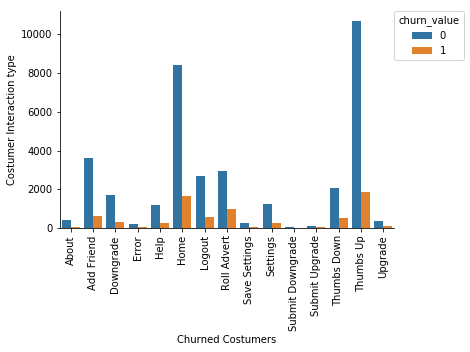

In [61]:
fig = sns.barplot(x='page', y='count', hue='Churn', data=df_usr.toPandas())
plt.xlabel('Churned Costumers')
plt.ylabel('Costumer Interaction type')
plt.xticks(rotation=90) 
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., title='churn_value')
sns.despine(ax=fig);

In [62]:
#Checking impact of userAgent on the churn

In [64]:
def findBrowser(x):
    if 'Firefox' in x:
        return 'Firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'Chrome'
        else:
            return 'Safari'
    elif 'Trident' in x:
        return 'IE'
    else:
        return np.NaN
    
    
def findPlatform(x): 
    return platforms[re.findall(r'\(([^\)]*)\)',x)[0].split(';')[0]]

platforms = {'Windows NT 5.1': 'Windows','Windows NT 6.0': 'Windows', 'Windows NT 6.1': 'Windows',  
          'Windows NT 6.2': 'Windows',  'Windows NT 6.3': 'Windows', 'X11': 'Linux','compatible': 'Windows',  'iPad': 'iPad',  'iPhone': 'iPhone',  
          'Macintosh': 'Mac'}

In [65]:
temp = df_churn.toPandas()

In [66]:
temp['browser'] = temp['userAgent'].apply(findBrowser)

In [67]:
df_browser = temp.groupby(['browser','Churn']).count()[['Churn_test']].reset_index()
df_browser

,browser,Churn,Churn_test
0,Chrome,0,125030
1,Chrome,1,20561
2,Firefox,0,40799
3,Firefox,1,14847
4,IE,0,13566
5,IE,1,1781
6,Safari,0,53895
7,Safari,1,7675


In [1]:
print('Chrome browser churn percentage:', 20561/125030)
print('Firefox browser churn percentage:', 14847/40799)
print('IE browser churn percentage:', 1781/13566)
print('Safari browser churn percentage:', 7675/53895)

Chrome browser churn percentage: 0.16444853235223547
Firefox browser churn percentage: 0.3639059780876982
IE browser churn percentage: 0.13128409258440218
Safari browser churn percentage: 0.14240653121810928


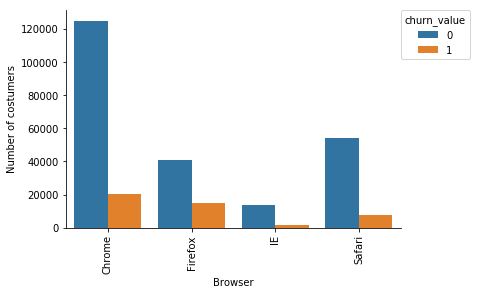

In [68]:
fig = sns.barplot(x='browser', y='Churn_test', hue='Churn', data=df_browser)
plt.xlabel('Browser')
plt.ylabel('Number of costumers')
plt.xticks(rotation=90) 
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., title='churn_value')
sns.despine(ax=fig);

In [69]:
temp['platform'] = temp['userAgent'].apply(findPlatform)

In [70]:
df_platform = temp.groupby(['platform','Churn']).count()[['Churn_test']].reset_index()
df_platform

,platform,Churn,Churn_test
0,Linux,0,7199
1,Linux,1,1762
2,Mac,0,85394
3,Mac,1,17355
4,Windows,0,119134
5,Windows,1,24737
6,iPad,0,11381
7,iPhone,0,10182
8,iPhone,1,1010


In [3]:
print(' Linux users churn percentage:', 1762/7199)
print(' Mac users churn percentage:', 17355/85394)
print(' Windows users churn percentage:', 24737/119134)
print(' iPad users churn percentage:', 'no user churned(insuffucient data)')
print(' iPhone users churn percentage:', 1010/10182)

 Linux users churn percentage: 0.24475621614113072
 Mac users churn percentage: 0.2032344192800431
 Windows users churn percentage: 0.20764013631708833
 iPad users churn percentage: no user churned(insuffucient data)
 iPhone users churn percentage: 0.09919465723826361


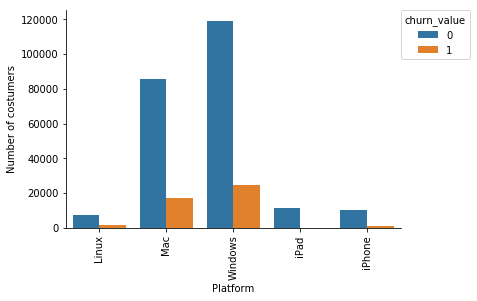

In [71]:
fig = sns.barplot(x='platform', y='Churn_test', hue='Churn', data=df_platform)
plt.xlabel('Platform')
plt.ylabel('Number of costumers')
plt.xticks(rotation=90) 
plt.legend(bbox_to_anchor=(1, 1), loc=2, borderaxespad=0., title='churn_value')
sns.despine(ax=fig);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [72]:
#registration time
reg_time = df_churn.select('userId','registration','ts').withColumn('lifetime',(df_churn.ts-df_churn.registration)) \
    .groupBy('userId').agg({'lifetime':'max'}).withColumnRenamed('max(lifetime)','lifetime') \
    .select('userId', (F.col('lifetime')/1000/3600/24).alias('lifetime'))

reg_time.show(5)

+------+------------------+
|userId|          lifetime|
+------+------------------+
|100010|  55.6436574074074|
|200002| 70.07462962962963|
|   125| 71.31688657407408|
|    51|19.455844907407407|
|   124|131.55591435185184|
+------+------------------+
only showing top 5 rows



In [73]:
#listened artist 
lis_artist = df_churn.filter(df_churn.page=="NextSong").select("userId", "artist").dropDuplicates() \
    .groupby("userId").count().withColumnRenamed("count", "artist_count")

lis_artist.show(5)

+------+------------+
|userId|artist_count|
+------+------------+
|100010|         252|
|200002|         339|
|   125|           8|
|    51|        1385|
|   124|        2232|
+------+------------+
only showing top 5 rows



In [74]:
#thumbs up count
thumbUp = df_churn.select('userID','page').where(df_churn.page == 'Thumbs Up').groupBy('userID') \
    .count().withColumnRenamed('count', 'thumbsUp') 

thumbUp.show(5)

+------+--------+
|userID|thumbsUp|
+------+--------+
|100010|      17|
|200002|      21|
|    51|     100|
|   124|     171|
|     7|       7|
+------+--------+
only showing top 5 rows



In [87]:
#thumbs down count
thumbDown = df_churn.select('userID','page').where(df_churn.page == 'Thumbs Down').groupBy('userID') \
    .count().withColumnRenamed('count', 'thumbsDown') 

thumbDown.show(5)

+------+----------+
|userID|thumbsDown|
+------+----------+
|100010|         5|
|200002|         6|
|    51|        21|
|   124|        41|
|     7|         1|
+------+----------+
only showing top 5 rows



In [76]:
#additon to playlist count
add_playlist = df_churn.select('userID','page').where(df_churn.page == 'Add to Playlist').groupBy('userID') \
    .count().withColumnRenamed('count', 'add_to_playlist')

add_playlist.show(5)

+------+---------------+
|userID|add_to_playlist|
+------+---------------+
|100010|              7|
|200002|              8|
|    51|             52|
|   124|            118|
|     7|              5|
+------+---------------+
only showing top 5 rows



In [78]:
#listened songs in session count
session_songs = df_churn.where('page == "NextSong"').groupby(['userId', 'sessionId']).count().groupby(['userId']) \
    .agg({'count':'avg'}).withColumnRenamed('avg(count)', 'avg_songs_played')

session_songs.show(5)

+------+------------------+
|userId|  avg_songs_played|
+------+------------------+
|100010|39.285714285714285|
|200002|              64.5|
|   125|               8.0|
|    51|             211.1|
|   124|145.67857142857142|
+------+------------------+
only showing top 5 rows



In [79]:
#total added friends
added_friends = df_churn.select('userID','page').where(df_churn.page == 'Add Friend').groupBy('userID') \
    .count().withColumnRenamed('count', 'add_friend') 

added_friends.show(5)

+------+----------+
|userID|add_friend|
+------+----------+
|100010|         4|
|200002|         4|
|    51|        28|
|   124|        74|
|     7|         1|
+------+----------+
only showing top 5 rows



In [81]:
# total gender
tot_gen = df_churn.select("userId", "gender").dropDuplicates().replace(['M', 'F'], ['0', '1'], 'gender') \
    .select('userId', F.col('gender').cast('int'))

tot_gen.show(5)

+------+------+
|userId|gender|
+------+------+
|    44|     1|
|    46|     1|
|    41|     1|
|    72|     1|
|300023|     1|
+------+------+
only showing top 5 rows



In [83]:
#churn column
churn = df_churn.select('userId', F.col('churn').alias('label')).dropDuplicates()

churn.show(5)

+------+-----+
|userId|label|
+------+-----+
|100010|    0|
|200002|    0|
|   125|    1|
|   124|    0|
|    51|    1|
+------+-----+
only showing top 5 rows



In [88]:
#joining for getting desired features

In [89]:
df_joined = reg_time.join(lis_artist,'userID','outer').join(thumbUp,'userID','outer').join(thumbDown,'userID','outer').join(add_playlist,'userID','outer').join(session_songs,'userID','outer').join(added_friends,'userID','outer').join(tot_gen,'userID','outer').join(churn,'userID','outer').drop('userID').fillna(0)

df_joined.show()

+------------------+------------+--------+----------+---------------+------------------+----------+------+-----+
|          lifetime|artist_count|thumbsUp|thumbsDown|add_to_playlist|  avg_songs_played|add_friend|gender|label|
+------------------+------------+--------+----------+---------------+------------------+----------+------+-----+
|  55.6436574074074|         252|      17|         5|              7|39.285714285714285|         4|     1|    0|
| 70.07462962962963|         339|      21|         6|              8|              64.5|         4|     0|    0|
| 71.31688657407408|           8|       0|         0|              0|               8.0|         0|     0|    1|
|131.55591435185184|        2232|     171|        41|            118|145.67857142857142|        74|     1|    0|
|19.455844907407407|        1385|     100|        21|             52|             211.1|        28|     0|    1|
| 72.77818287037037|         142|       7|         1|              5|21.428571428571427|        

In [91]:
df_joined.count()

225

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [118]:
#converting to scaled values using standardsacler and vector assembler

In [116]:
cols = df_joined.columns
cols.remove('label')

df_vector = VectorAssembler(inputCols=cols, outputCol="vectorised").transform(df_joined)

In [142]:
model_scal = StandardScaler(inputCol="vectorised", outputCol="features", withStd=True).fit(df_vector)
df_scaled = model_scal.transform(df_vector)

In [143]:
df_scaled.show(5, False)

+------------------+------------+--------+----------+---------------+------------------+----------+------+-----+------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------+
|lifetime          |artist_count|thumbsUp|thumbsDown|add_to_playlist|avg_songs_played  |add_friend|gender|label|vectorised                                                              |features                                                                                                                                                    |
+------------------+------------+--------+----------+---------------+------------------+----------+------+-----+------------------------------------------------------------------------+---------------------------------------------------------------------------------------------------------------------------------

In [144]:
#splitting into test train
train, test = df_scaled.randomSplit([0.7, 0.3])
val, testVal = test.randomSplit([0.5, 0.5])

In [145]:
train.count(), test.count(), val.count(), testVal.count()

(169, 56, 30, 26)

## Base Line Model

In [154]:
#baseline evaluator model
evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")

In [149]:
#base line model for not Churn
bl0 = testVal.withColumn('prediction', F.lit(0.0))

print('Not Churn BaseLine Evaluation')
print('F1 Score:', evaluator.evaluate(bl0, {evaluator.metricName: "f1"}))
print('Accuracy:', evaluator.evaluate(bl0, {evaluator.metricName: "accuracy"}))

Not Churn BaseLine Evaluation
F1 Score: 0.8304552590266875
Accuracy: 0.8846153846153846


In [150]:
#base line model for Churn
bl1 = testVal.withColumn('prediction', F.lit(1.0))

print('Churn BaseLine Evaluation')
print('F1 Score:', evaluator.evaluate(bl1, {evaluator.metricName: "f1"}))
print('Accuracy:', evaluator.evaluate(bl1, {evaluator.metricName: "accuracy"}))

Churn BaseLine Evaluation
F1 Score: 0.02387267904509284
Accuracy: 0.11538461538461539


## Gradient Boost

In [146]:
#initializing
gbt = GBTClassifier(maxIter=5,seed=42)

cv_gbt = CrossValidator(estimator=gbt,
                          estimatorParamMaps=ParamGridBuilder().build(),
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)

In [147]:
model = cv_gbt.fit(train)

model.avgMetrics

[0.6930601590081977]

In [152]:
bgt_val = model.transform(val)

In [155]:
print('Gradient Boost Evaluation')
print('F1 Score:', evaluator.evaluate(bgt_val, {evaluator.metricName: "f1"}))
print('Accuracy:', evaluator.evaluate(bgt_val, {evaluator.metricName: "accuracy"}))

Gradient Boost Evaluation
F1 Score: 0.743939393939394
Accuracy: 0.7333333333333333


## SVM

In [156]:
#initializing
svm = LinearSVC(maxIter=5)

cv_svm = CrossValidator(estimator=svm,
                          estimatorParamMaps=ParamGridBuilder().build(),
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)

In [157]:
model_svm = cv_svm.fit(train)

model_svm.avgMetrics

[0.6467248631106551]

In [158]:
val_svm = model_svm.transform(val)

In [159]:
print('SVM Evaluation')
print('F1 Score:', evaluator.evaluate(val_svm, {evaluator.metricName: "f1"}))
print('Accuracy:', evaluator.evaluate(val_svm, {evaluator.metricName: "accuracy"}))

SVM Evaluation
F1 Score: 0.6654088050314467
Accuracy: 0.7666666666666667


## Random Forest

In [162]:
#initializing
rf = RandomForestClassifier()

cv_rf = CrossValidator(estimator=rf,
                          estimatorParamMaps=ParamGridBuilder().build(),
                          evaluator=MulticlassClassificationEvaluator(metricName='f1'),
                          numFolds=3)

In [163]:
model_rf = cv_rf.fit(train)

model_rf.avgMetrics

[0.723260898762692]

In [164]:
val_rf = model_rf.transform(val)

In [165]:
print('Random Forest Evaluation')
print('F1 Score:', evaluator.evaluate(val_rf, {evaluator.metricName: "f1"}))
print('Accuracy:', evaluator.evaluate(val_rf, {evaluator.metricName: "accuracy"}))

Random Forest Evaluation
F1 Score: 0.7132897603485837
Accuracy: 0.7666666666666667


Out of Gradient Boost, SVM and Random Forest:
- Gradient Boost have the worst accuracy of all three (Accuracy: 0.7333333333333333)
- SVM and Random Forest have similar accuracies (Accuracy: 0.7666666666666667) but F1 score of Random Forest(F1 Score: 0.7132897603485837) is better than F1 score of SVM(F1 Score: 0.6654088050314467). Therefore, exploring the important values of Random Forest.

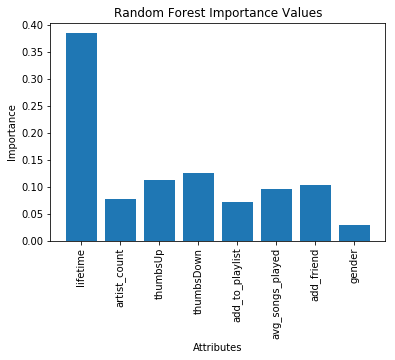

In [188]:
#plotting important values for random forest to analyse it
y_pos = np.arange(len(cols))
 
plt.bar( y_pos,model_rf.bestModel.featureImportances.values, align='center')

plt.ylabel('Importance')
plt.xlabel('Attributes')
plt.xticks(y_pos, cols, rotation=90)
plt.title('Random Forest Importance Values');

From the raph, we can see that liftetime, thumbsDown, thumbsUp, add_friend, avg_songs_played, add_to_playlist have a considerabe amount of infulence on the churn prediction. 
The result is kind of obvious and follows human behaviour. 
- Not churned used will spend more time in comparision to Churned user
- thumbsDown shows that, proper recomendation of songs was not given to the user. Hence, more likely to churn
- thumbsUp shows that, proper recomendation of songs was given to the user. Hence, more likely to stay
- add_friend shows that, more interaction with app. 
- avg_songs_played and add_to_playlist shows user spent more time on app and listened and saved more songs.


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.